In [ ]:
from molsim import MolecularDynamics
import matplotlib.pyplot as plt
import numpy as np

# Exercise 3: Lennar-Jones Molecular Dynamics

The MD program consists of a main MolecularDynamics object, found in `src/molecularDynamics/md.h`. The object has a constructor, that allows you to set a bunch of different settings that you might want to use in this simulation. Furthermore you will find the thermostats in `src/molecularDynamics/thermostats.h` and some samplers in `src/molecularDynamics/samplers.h`.

### MolecularDynamics object
The `MolecularDynamics` struct has a bunch of different functions. First there is the constructor `MolecularDynamics::MolecularDynamics`, which, from the input settings, sets up the simulation. First it precomputes some properties, like volume and density. Secondly, it initializes the velocities according the Maxwell-Boltzmann distribution (note that because mass = 1, in this case and therefore momentum = velocity). 

It also initializes all positions on a cubic lattice by calling `MolecularDynamics::latticeInitialization`, which prevents overlaps from happening, but a further minimization to the closest local minimum is done by `MolecularDynamics::gradientDescent`.

### Force calculation and integration
In MD one propagates the system by integrating the equations of motion. The integrator used for the equations of motion is the velocity Verlet integrator, which is a symplectic integrator. This means that the Hamiltonian is conserved, or, in other words, the drift or error in the ideally constant Hamiltonian is bounded. The Hamiltonian for an NVE system is (settings $m=1$)

$\mathcal{H}(p, q) = \sum_i^{N} \frac{p_i^2}{2} + \mathcal{U}(q)$

yielding the equations of motion:

$\dot{q} = \frac{\partial \mathcal{H}}{\partial p} = \frac{p}{m}$

$\dot{p} = -\frac{\partial \mathcal{H}}{\partial q} = -\frac{\partial \mathcal{U}}{\partial q}$.

In the velocity verlet algorithm these equations of motion are governed by updating the velocity in two half steps, once with the forces at time $t$ and once with the forces at time $t+\Delta t$.

This leads to integration scheme:

$v(t + \frac{\Delta t}{2}) = v(t) + F(t) \frac{\Delta t}{2}$

$q(t + \Delta t) = q(t) + v(t) \Delta t + F(t) \frac{(\Delta t)^2}{2}$

$v(t + \Delta t) = v(t + \frac{\Delta t}{2}) + F(t + \Delta t) \frac{\Delta t}{2}$

where

$F(t) = -\frac{\partial \mathcal{U}(q(t))}{\partial q}$.

In the code this force term is calculated in the method `MolecularDynamics::calculateForce`. This is the most computationally demanding function as it is a loop over all particle pairs. It can be nicely combined with computing the potential energy and the virial, which is used in the pressure. All particles have interaction with eachother according to the so-called Lennard-Jones potential - which has a repulsive term $r^{-12}$, which can be seen as the Pauli repulsion and an attraction term $r^{-6}$, which is often called the van der Waals term, as the van der Waals interaction also diminishes with $r^{-6}$. 

$\mathcal{U}(q) = \frac{1}{2} \sum_i^N \sum_{j \neq i}^N U_{LJ}(r_{ij})$

where

$r_{ij} = |q_i - q_j|$

and 

$U_{LJ}(r_{ij}) = 4 \epsilon \left((\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^{6} \right)$.

This force is then used in `MolecularDynamics::integrate` to sequentially update the momenta, positions and forces in given the steps in the equations of motion. At the same time, it might also make calls to the thermostat, which allows us to run a constant temperature simulation.

### Thermostats
In this tutorial we use just NVE (constant number of particles N, volume V and energy E) simulations. However, during the equilibration the kinetic energy is kept constant. While we do a constant energy simulation, it is preferable to give an input temperature, as this is more natural when doing research. Early on there might still be large shifts in kinetic energy due to the equilibration and therefore we keep it constant, using a `VelocityScaling` thermostat. This thermostat simply rescales the velocities to exactly reproduce the input temperature and therefore does not conserve energy and therefore does not sample the NVE ensemble.

## Question 1
Run your first MD simulation with this program. 
In the cell under this cell you will find the constructor and the run methods of the MD package. Familiarize yourself with the method of setting this up and the different arguments given.

In [ ]:
# Initialize MD simulation
md = MolecularDynamics(
    numberOfParticles=200,
    temperature=1.0,
    dt=0.005,
    boxSize=8.0,
    numberOfEquilibrationSteps=int(1e4),
    numberOfProductionSteps=int(1e4),
    outputPDB=True,
    logLevel=0,
    seed=12,
    sampleFrequency=10,
)
# Run MD simulation
md.run()

Run this simulation with outputPDB set to `true`. This will generate a file named `movie.pdb` in the current directory. Let's view the movie:

In [ ]:
import nglview as nv
import MDAnalysis as mda

movie = mda.Universe("movie.pdb")
view = nv.show_mdanalysis(movie)
view.add_unitcell()
view.remove_ball_and_stick()
view.camera = "orthographic"
view.add_spacefill(radius=0.4, color="pink")
view

If the notebook NGLview-viewer does not work, then visualize this file with your favourite visualization software (ie. ovito, vmd, ...).

## Question 2
How is one able to control the temperature in this program? After all, the total energy of the system should be constant (not the temperature) and see how the kinetic energy scales with temperature.

Plot the `kineticEnergies` and `observedTemperatures` of two different input temperatures.

In [ ]:
# Initialize MD simulation
md_T2 = MolecularDynamics(
    numberOfParticles=200,
    temperature=2.0,
    dt=0.005,
    boxSize=8.0,
    numberOfEquilibrationSteps=int(1e4),
    numberOfProductionSteps=int(1e4),
    outputPDB=True,
    logLevel=0,
    seed=12,
    sampleFrequency=10,
)
# Run MD simulation
md_T2.run()

In [ ]:
# Plot results
fig, ax = plt.subplots(2, 1)

# start implementation
ax[0].plot(md.time, md.kineticEnergies, label="T_input = 1.0")
ax[0].plot(md_T2.time, md_T2.kineticEnergies, label="T_input = 2.0")
ax[0].legend()

# Plot observed temperatures
ax[1].plot(md.time, md.observedTemperatures, label="T_input = 1.0")
ax[1].plot(md_T2.time, md_T2.observedTemperatures, label="T_input = 2.0")
ax[1].legend()
# end implementation

ax[0].set_xlabel(r"time / $\tau$")
ax[0].set_ylabel(r"E$_{kin}$ / $\varepsilon$")

ax[1].set_xlabel(r"time / $\tau$")
ax[1].set_ylabel(r"T / $\varepsilon$")

fig.tight_layout()

## Question 3
To test the energy drift $\Delta E$ of the numerical integration algorithm for a given time step $\Delta t$ after $N$ integration steps, one usually computes

\begin{equation}
\Delta E\left(\Delta t\right) = \frac{1}{N} \sum_{i=1}^{i=N} \left|
\frac{E\left(0\right) - E\left(i\Delta t\right)}{E\left(0\right)}
\right|
\end{equation}

In this equation, $E\left(t\right)$ is the total energy (kinetic+potential) of the system at time $t$. The program
prints the average drift at the end of the run. To prevent drift, the timestep should be reasonably small given the
system density. High density leads to larger forces, which lead to larger errors. Test to see how high you can push the
timestep before the system starts to diverge. 

## Answer
I noticed that at 0.05 for the timestep the results diverged and I got nans for answers.

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 6))

# start implementation

sim_results_stable = {}
timesteps_to_test_stable = [0.001, 0.005, 0.01, 0.05]
for dt_val in timesteps_to_test_stable:
    print(f"Running simulation for Q3 (stable test) with dt = {dt_val}")
    md_sim = MolecularDynamics(
        numberOfParticles=200,
        temperature=2.0,
        boxSize=8.0,
        numberOfEquilibrationSteps=int(1e4),
        numberOfProductionSteps=int(1e4),
        outputPDB=True,
        logLevel=0,
        seed=12,
        sampleFrequency=10,
        dt=dt_val
    )
    md_sim.run()
    sim_results_stable[dt_val] = (md_sim.time, md_sim.conservedEnergies)

for dt_val, (time_data, energy_data) in sim_results_stable.items():
    ax.plot(time_data, energy_data, label=f"dt = {dt_val}")
# end implementation

ax.set_xlabel(r"Time, t / $\tau$")
ax.set_ylabel(r"Energy, E / $\varepsilon$")
ax.legend()

## Comment
I think the code block below here is a bit redundant since I already plot multiple time steps in the code block above.

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 6))

# start implementation

# end implementation

ax.set_xlabel(r"Time, t / $\tau$")
ax.set_ylabel(r"Energy, E / $\varepsilon$")
ax.legend()

## Question 4
An important property of symplectic integrators is that they are time reversible. Can you run the simulation with a
negative timestep? Do you expect a difference given the Equations of motion?

## Answer
No I do not expect a difference in the equations of motions are time reversible. This is confirmed by the plot below,
while the energies are negative they still fluctuate around the mean value of -259. These fluctuations are due to the bounded
error. However it was interesting to see that the energy is negative.

In [ ]:
# Initialize MD simulation
md_rev = MolecularDynamics(
    numberOfParticles=200,
    temperature=1.0,
    dt=-0.005,
    boxSize=8.0,
    numberOfEquilibrationSteps=int(1e4),
    numberOfProductionSteps=int(1e5),
    outputPDB=True,
    logLevel=0,
    seed=12,
    sampleFrequency=1000,
)
# Run MD simulation
md_rev.run()

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(md_rev.time, md_rev.conservedEnergies, label="Conserved")

ax.set_xlabel(r"Time, t / $\tau$")
ax.set_ylabel(r"Energy, E / $\varepsilon$")
ax.legend()

## Question 5
The radial distribution function is an important tool to analyze the average local environment of particles. The ensemble average over all pairs of the pair distribution is defined as:

\begin{equation}
g(r) = \frac{2V}{N^2} \langle \sum_{i < j} \delta(r - r_{ij}) \rangle
\end{equation}

Generally, in a simulation, a delta function is not tractable, but a binning algorithm with a reasonable amount of bins will do. Which is also implemented in the `MolecularDynamics` program. In a liquid of spherically symmetric molecules $g(r)$ depends on the distance between the molecules. These definitions are useful since we can use them to give the probability of observing a molecule at r, given that we have a molecule at the origin. The function $\rho g(r)$ gives the local density of particles, given there is a molecule at the origin. Using the spherical volume element (and the spherical symmetry of the molecule that we have assumed) we can calculate the probability as follows:

\begin{equation}
\int_0^{\infty} \rho g(r) 4 \pi r^2 dr = N -1
\end{equation}

The integral states that there are N-1 particles outside the central particle we are observing. The ensemble average of any pair function may be expressed in this form

\begin{equation}
\langle \mathcal{A} \rangle = \frac{N}{2} \rho \int_0^\infty a(r) g(r) 4 \pi r^2 dr
\end{equation}

This can be used to calculate the average energy $\langle U \rangle$ or the potential of mean force (PMF) using the relation $w(r) = -k_BT \log(g(r))$. Another use is with Kirkwood-Buff integrals to calculate the activity coefficient or solubility.

One thing that is very immediately clear from a radial distribution function is the amount of order that can be found in the local environment. Generate the radial distribution for three different phases of the Lennard-Jones system: gas, liquid and solid. The MD program automatically samples the RDF, you can retrieve it by asking the sampler for results with `md.rdfSampler.getResults()`. This returns a $(N, 2)$ array, with pairs of values $(r, g(r))$ for $N$ different bins. 

What are the obvious differences between the RDF's of the three phases? Why is there no particle to be found in the region between 0 and approximately 1 $\sigma$?

**Hint**: Have a look at the phase diagram provided in Basic MC for the input settings.


## Answer
The rdf graph of the solid is very different from the others and it shows the strongest evidence of order and
structuring. This is evidenced by the two sharp peaks at 1.2 and 1.8 $\frac{r}{\sigma}$. This also corresponds to the
phase diagram provided in Notebook 3, where my particular values for temperature and density correspond to a Face
Centred Cubic Crystal structure.

Secondly we notice that there is a pronounced peak in the rfd for the liquid phase around 1.5 $\frac{r}{\sigma}$ similar
to the solid phase. However, one important thing to note is that the RDF for the liquid phase is a bit more spread out
than the one for the solid phase. Which aligns with the fact that liquids have less structural order when compared to solids.

Finally, for the gas phase again we notice a pronounced peak around 1.2 $\frac{r}{\sigma}$ similar to the solid and
liquid phase. But also we notice that it is even more uniform than the previous phases indicating that there is a very
minimal amount of ordering or structuring in the gas phase. Which is what we expect.


As to why there is no particle to be found in the region between 0 and approximately 1 $\sigma$? This is due to the
strong intermolecular forces as $r \rightarrow 0$. When this happens, $U_{LJ}(r)$ goes to infinity, indicating a strong
repulsive force. We can also notice this when considering a statistical thermodynamic approach. We know that the
probability of observing a certain configuration is proportional to $e^{-U_{LJ}(r)/k_BT}$. As $r \rightarrow 0$ and
$U_{LJ}(r) \rightarrow \infty$, $e^{-U_{LJ}(r)/k_BT} \rightarrow 0$, therefore the probability of observing such a
configuration is very close to 0. This very high positive energy happens in the region between 0 and 1$\sigma$ making
the likelihood of having particles in this region very very low and hence we do not see any particles in this region.

In [ ]:
# Plot results
fig, ax = plt.subplots()

# get rdf and plot
# start implementation
phases = {
    "Gas":    {"temperature": 1.0, "density": 0.1, "label": r"Gas ($T^*=1.0, \rho^*=0.1$)"}, # Refined based on diagram
    "Liquid": {"temperature": 1.0, "density": 0.8, "label": r"Liquid ($T^*=1.0, \rho^*=0.7$)"},
    "Solid":  {"temperature": 0.5, "density": 1.1, "label": r"Solid$^{fcc}$ ($T^*=0.5, \rho^*=1.0$)"} # Added fcc to label
}

common_params_q5 = {
    "numberOfParticles": 200,
    "dt": 0.005,
    "numberOfEquilibrationSteps": int(2e4),
    "numberOfProductionSteps": int(2e4),
    "outputPDB": False,
    "logLevel": 1,
    "seed": 456,
    "sampleFrequency": 100
}

for phase_name, params in phases.items():
    N = common_params_q5["numberOfParticles"]
    rho = params["density"]
    box_size = (N / rho)**(1/3.0)

    print(f"Running simulation for {phase_name} phase...")
    print(f"  T* = {params['temperature']}, rho* = {rho}, boxSize = {box_size:.2f}")

    md_sim_phase = MolecularDynamics(
        **common_params_q5,
        temperature=params["temperature"],
        boxSize=box_size
    )
    md_sim_phase.run()

    rdf_data = md_sim_phase.rdfSampler.getResults()
    if rdf_data is not None and rdf_data.shape[0] > 0:
        r_coords = rdf_data[:, 0]
        g_r_values = rdf_data[:, 1]
        ax.plot(r_coords, g_r_values, label=params["label"])
    else:
        print(f"Warning: No RDF data obtained for {phase_name}")



# end implementation

ax.legend()
ax.set_xlabel(r"r / $\sigma$")
ax.set_ylabel("g(r)")

## Question 6
An important quantity of a liquid or gas is the so-called self-diffusion coefficient $D$. Here we calculate $D$ in a three-dimensional system. There are two methods to calculate $D$:

1.by integrating the velocity auto-correlation function (VACF):
\begin{equation}
D = \frac{1}{3}\int_{0}^{\infty} \left\langle {\bf
v}\left(t\right)\cdot {\bf v}\left(t+t^{'}\right) \right\rangle
dt^{'}\nonumber\\ 
= \frac{\int_{0}^{\infty} \sum_{i=1}^{i=N}
\left\langle{\bf v}\left(i,t\right)\cdot{\bf v}\left(i,t +
t^{'}\right)\right\rangle dt^{'}}{3N}
\end{equation}
in which $N$ is the number of particles and ${\bf v}\left(i,t\right)$ is the velocity of particle $i$ at time $t$. One should choose $t$ in such a way that independent time origins are taken, \emph{i.e.} $t = ia\Delta t$, $i=1,2, \cdots , \infty$ and $\left\langle {\bf v}\left(t\right)\cdot{\bf v}\left(t+a\Delta t\right)\right\rangle \approx {\bf 0}$ 


2.by calculating the mean-squared displacement:
\begin{equation}
D = \lim_{t^{'} \rightarrow \infty} \frac{\left\langle \left|{\bf
x}\left(t + t^{'}\right) - {\bf x} \left(t\right)\right|^{2}
\right\rangle}{6t^{'}}
\end{equation}

One should be careful with the mean-squared displacement calculation when periodic boundary conditions are used. Why?
Calculate self-diffusion coefficient using both methods.

Hint:The MD program automatically samples the MSD, you can retrieve it by asking the sampler for results with
`md.msdSampler.getResults()`, in which normalizedMSD[i] = meanSquareDisplacements[i] / (numberOfParticles *
sampleCounts[i]); normalizedVACF[i] = velocityAutocorrelation[i] / (numberOfParticles * sampleCounts[i]).



## Answer
When particles cross periodic boundaries, their stored coordinates "wrap around." If you calculate displacement naively using these wrapped coordinates, a particle that crossed a boundary might appear to have made a huge jump in the opposite direction. To correctly calculate MSD with PBC, you need to "unwrap" the trajectory, meaning you account for boundary crossings to get the true continuous displacement.

[INFO]:  Class MD created.
[INFO]:  numGrids 7 gridSize 0.731815
[INFO]:  (Init) completed. Final energy: -1310.593478
[INFO]:  Thermodynamical averages
----------------------------
Temperature          : 1.082411 ± 0.002523
Pressure             : 0.567619 ± 0.010106
Potential energy     : -880.497271 ± 0.739784
Kinetic energy       : 323.099738 ± 0.753109
Conserved energy     : -557.397533 ± 0.013769



/tmp/ipykernel_99161/1719383930.py:21: RuntimeWarning: invalid value encountered in divide
  d_msd = normalizedMSD / (6.0 * t)


Text(0, 0.5, 'D')

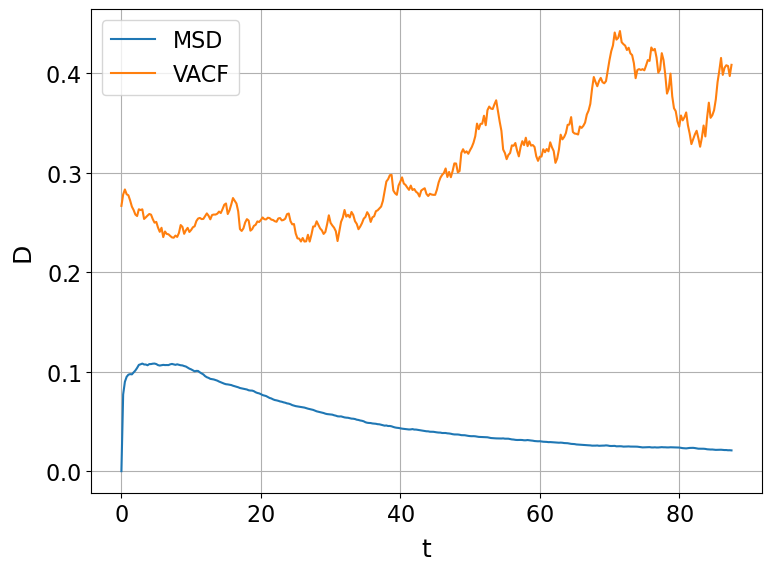

In [25]:
#Run a liquid sim really quick
md = MolecularDynamics(
    numberOfParticles=200,
    temperature=1.0,
    dt=0.005,
    boxSize=(200/0.7)**(1/3.0), # Liquid density ~0.7
    numberOfEquilibrationSteps=int(1e4),
    numberOfProductionSteps=int(2e4),
    outputPDB=False,
    logLevel=1,
    seed=789,
    sampleFrequency=50)
md.run()

msd = md.msdSampler.getResults()
fig, ax = plt.subplots()
t = msd[:, 0]
normalizedMSD = msd[:, 1]
normalizedVACF = msd[:, 3]
# start implementation
d_msd = normalizedMSD / (6.0 * t)
d_msd[0] = 0.0

dt = np.diff(t)                      
# trap areas between each pair of points
areas = 0.5 * (normalizedVACF[:-1] + normalizedVACF[1:]) * dt  
# cumulative integral, with D_vacf(0)=0
D_vacf = np.empty_like(normalizedVACF)
D_vacf[0] = 0.0
D_vacf[1:] = np.cumsum(areas) / 3.0
# end implementation
ax.plot(t,d_msd, label=r"MSD")
ax.plot(t,d_vacf, label=r"VACF")
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("D")